# Modelo de Amarre Fuerte
*Andrés Gómez Arias y Stefan Daniel Nellen Mondragón*

Se implementaron un modelo de amarre fuerte para orbitales s y p como función de la clase cristal. Mediante esto modelo se implementaron funciones para calcular la estructura de bandas y la densidad de estados del cristal. El método es aplicable a vecinos de orden arbitrario con funciones de peso arbitrarias (minetras sean $L^2$ y estén correctamente normalizadas) y parámetros de Slater-Koster. Lo único que se hizo por separado fue el programa que encuentra vecinos. Usamos el de Andrés pues trabajamos en su computadorea durante las clases.

La estructura de bandas usa los métodos de diagonalización de numpy y los caminos recomendados en clase.

La densidad de estados se calculó mediante dos métodos, DOS y DOS2. DOS usa el método  Gilat-Raubenheimer para calcular deltas de funciones esclares con argumentos vectoriales y DOS2 aproxima la delta con una gaussiana e integra a orden 0. DOS debería ser una aproximación _mucho_ mejor que DOS2 sin tardarse más tiempo, sin embargo y por desgracia, DOS no lo logramos completar, esto se debe a que requiere del cálculo del gradeinte del campo de energías y el cálculo del área de un plano que interseca a un paralelepípedo. Tanto en el gradiente como en el cálculo del área se han encontrado problemas que no se lograron arreglar a tiempo. No obstante, DOS2 da un aproximación bastante parecida a la que se tiene en el moodle.

Nótese que el cálculo de la densidad de estados es muy lento, se hicieron distintas pruebas, encontrando que 90% del tiempo se tarda el programa en diagonalizar el Hamiltoniano en cada punto de la malla. Esto es en gran parte lo que inhibio nuestra habilidad de encontrar los errores en DOS a tiempo. Además, dada esta constricción no fue posible generar una densidad de estados con muchos puntos.

Los parámetros que se usaron para Silicio y Germanio fueron tomados de: _Yu, Cardona. Fundamentals of Semiconductors. Springer, 2010._ Los demás se inventaron (para ver y probar la generalidad del programa) o se copiaro de Si o Ge, es decir estos no necesariamente representan sistemas físicos reales.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import sympy as sy

In [2]:
#%matplotlib notebook
%matplotlib inline

Se definen la Gaussiana y la función de el área del plano encastrado en un paralelepípedo.

In [3]:
def gauss(x, mu, sigma):
    return np.exp(-(x-mu)**2/(4*sigma))/(2*np.pi*np.sqrt(sigma*np.pi))

def Theta(t): #Función triángulo
    if t >= 0:
        return t
    return 0

def Heaviside(t):
    if t >= 0:
        return 1
    return 0

def Superficie(M, b, A, E):
    '''
    Calcula el área de la superficie dada por el plano M*K-b = 0, donde M es el vector normal al plano, intersectada con el
    paralelepípedo formado por los vectores ai en A = [a1,a2,a3].
    Se espera que M sea array de 1x3 y A de 3x3
    '''
    Ainv = np.linalg.inv(A)
    S = 0
    Mnorm = np.linalg.norm(M)
    #Mp = np.matmul(M,Ainv) #Original
    Mp = np.matmul(M,A.T)
    Mpnorm = np.linalg.norm(Mp)
    b = b/Mpnorm #Reescalamos constante y vector tq Mp esté normalizado
    Mp = Mp/Mpnorm
    #print('Mp = '+str(Mp))
    #print('b = '+str(b))
    if not np.any(np.abs(Mp) < E): #No hay coordenadas cero
        Vpos = np.array([[0,0,0],[0,1,1],[1,0,1],[1,1,0]])
        Vneg = np.array([[1,0,0],[0,1,0],[0,0,1],[1,1,1]])
        for v in Vpos:
            S += Theta(b-np.dot(v,Mp))**2
        for v in Vneg:
            S -= Theta(b-np.dot(v,Mp))**2
        return S*Mnorm/(2*Mpnorm*np.linalg.det(Ainv)*Mp[0]*Mp[1]*Mp[2])
    else: #Tenemos algún Mp igual a cero, el plano es perpendicular a alguna de las caras y la formula debe ser modificada
        Mcero = []
        Mnocero = []
        for m in Mp:
            if abs(m) < E:
                Mcero.append(m)
            else:
                Mnocero.append(m)
        if len(Mcero) == 1:
            Vpos = np.array([[0,0],[1,1]])
            Vneg = np.array([[0,1],[1,0]])
            for v in Vpos:
                S += Theta(b-np.dot(v,np.array(Mnocero)))
            for v in Vneg:
                S -= Theta(b-np.dot(v,np.array(Mnocero)))
            return S*Mnorm/(Mpnorm*np.linalg.det(Ainv)*Mnocero[0]*Mnocero[1])
        elif len(Mcero) == 2:
            Vpos = np.array([0])
            Vneg = np.array([1])
            S += Heaviside (b-np.dot(Vpos,np.array(Mnocero)))
            S -= Heaviside (b-np.dot(Vneg,np.array(Mnocero)))
            return S*Mnorm/(Mpnorm*np.linalg.det(Ainv)*Mnocero[0])
        else: #No hay plano
            return np.nan

In [4]:
def Integ(Energias,energia,B,E,N):
    '''
    Integración de delta(Energias(K)-energia) sobre el paralelepípedo dado por B = [V1,V2,V3]
    Ahorita tomamos g función escalar
    '''
    # Se calculan los centros de los los paralelepipedos        
    a = B[0]/N
    b = B[1]/N
    c = B[2]/N
    p = a/2 + b/2 + c/2
    #da, db, dc = np.linalg.norm(a), np.linalg.norm(b), np.linalg.norm(c)
    print('a = '+str(a))
    print('b = '+str(b))
    print('c = '+str(c))
    mesh = [] 
    #genera la red
    for i in range(N):
        m1 = []
        for j in range(N):
            m2 = []
            for l in range(N):
                m2.append((p+i*a+j*b+l*c))
            m1.append(m2)
        mesh.append(m1)
    mesh = np.array(mesh)
    
    #En = np.empty((len(Hk(0,0,0)),N,N,N))
    En = np.empty((len(Energias(0,0,0)),N,N,N))
    En = En.tolist()
    for i in range(N):
        for j in range(N):
            for l in range(N):
                Energ_vect = Energias(*mesh[i][j][l])
                for s in range(len(En)):
                    #En[s][i][j][l] = self.Energias(mesh[i][j][l], Hk)[s]
                    En[s][i][j][l] = Energ_vect[s]          
    En = np.array(En)
    gradE = np.array([np.gradient(En[s]) for s in range(0,len(En))]) #Gradiente direccional, falta el cambio de base

    #Se calcula la norma del gradiente ngradE[s][i][j][l] tiene la interpretacion normal
    #ngradE = np.linalg.norm(gradE, axis = 1)
    A = np.array([a,b,c])
    Ainv = np.linalg.inv(A)
    AinvT = Ainv.T
    print(Ainv)
    I = 0
    for s in range(len(En)):
        for i in range(N):
            for j in range(N):
                for l in range(N):
                    m = np.array([gradE[s][0][i][j][l], gradE[s][1][i][j][l], gradE[s][2][i][j][l]]) #Hacemos cambio de base de la derivada direccional para pasarla a cartesianas
                    m = np.matmul(m,AinvT)
                    #print('r = '+str(mesh[i][j][l]))
                    #print(m)
                    beta = energia - En[s][i][j][l]
                    S = Superficie(m, beta, A, E)
                    I += S/np.linalg.norm(m)

    #return I/((2*np.pi)**3)
    return I

In [5]:
#k = sy.symbols('k')
k1 = sy.symbols('k1')
k2 = sy.symbols('k2')
k3 = sy.symbols('k3')
K = np.array([k1,k2,k3])
sy.init_printing(use_unicode=True)

def Ejes (A, B, C, AB, BC, AC):
    '''
    Genera un Array de tres vectores X, Y, Z con módulo A, B, C y 
    ángulos entre ellos AB, BC, AC (en radianes).
    Fija la libertad de variables tomando X=(A1,0,0) y Y=(B1,B2,0)
    (Las expresiones salen de resolver las ecuaciones de producto punto entre los 3 vectores)
    '''
    p, q, r = np.around(A*B*np.cos(AB),4), np.around(B*C*np.cos(BC),4), np.around(A*C*np.cos(AC),4)
    X = np.array([A,0,0])
    Y = np.array([p/A, np.sqrt(B**2-p**2/A**2),0])
    Z = np.array([r/A, (q-p*r/A**2)/Y[1], np.sqrt(C**2-((q-p*r/A**2)/Y[1])**2-(r/A)**2)])
    return np.array([X,Y,Z])

def path(l, n):
    '''
    Genera una lista de coordenadas en 3 dadas por las rectas generadas por los puntos en l, con n puntos
    entre cada dos elementos de la lista
    '''
    x = []
    y = []
    z = []
    for i in range(len(l)-1):
        x0 = l[i][0]
        x1 = l[i+1][0]
        y0 = l[i][1]
        y1 = l[i+1][1]
        z0 = l[i][2]
        z1 = l[i+1][2]
        for j in range(n):
            x.append((x1-x0)*j/n + x0)
            y.append((y1-y0)*j/n + y0)
            z.append((z1-z0)*j/n + z0)
            if i == len(l)-2 and j == n - 1:
                x.append(x1)
                y.append(y1)
                z.append(z1)
            
    return np.array([x, y, z]).T

sc_special_points = {
    'cubic': {'G': [0, 0, 0],
              'M': [1 / 2, 1 / 2, 0],
              'R': [1 / 2, 1 / 2, 1 / 2],
              'X': [0, 1 / 2, 0]},
    'fcc': {'G': [0, 0, 0],
            'K': [3 / 8, 3 / 8, 3 / 4],
            'L': [1 / 2, 1 / 2, 1 / 2],
            'U': [5 / 8, 1 / 4, 5 / 8],
            'W': [1 / 2, 1 / 4, 3 / 4],
            'X': [1 / 2, 0, 1 / 2]},
    'bcc': {'G': [0, 0, 0],
            'H': [1 / 2, -1 / 2, 1 / 2],
            'P': [1 / 4, 1 / 4, 1 / 4],
            'N': [0, 0, 1 / 2]},
    'tetragonal': {'G': [0, 0, 0],
                   'A': [1 / 2, 1 / 2, 1 / 2],
                   'M': [1 / 2, 1 / 2, 0],
                   'R': [0, 1 / 2, 1 / 2],
                   'X': [0, 1 / 2, 0],
                   'Z': [0, 0, 1 / 2]},
    'orthorhombic': {'G': [0, 0, 0],
                     'R': [1 / 2, 1 / 2, 1 / 2],
                     'S': [1 / 2, 1 / 2, 0],
                     'T': [0, 1 / 2, 1 / 2],
                     'U': [1 / 2, 0, 1 / 2],
                     'X': [1 / 2, 0, 0],
                     'Y': [0, 1 / 2, 0],
                     'Z': [0, 0, 1 / 2]},
    'hexagonal': {'G': [0, 0, 0],
                  'A': [0, 0, 1 / 2],
                  'H': [1 / 3, 1 / 3, 1 / 2],
                  'K': [1 / 3, 1 / 3, 0],
                  'L': [1 / 2, 0, 1 / 2],
                  'M': [1 / 2, 0, 0]}}

In [6]:
class Red(object):
    """Clase que representa una red (retícula)
    
    Esencialmente, es un arreglo de tres vectores. Se asume que las unidades son Angstrom.
    
    """
    
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, a1, a2, a3):
        """
        Crear una red a partir de tres vectores. Se asume que las unidades son Angstrom.
        
        Argumentos:
          a1, a2, a3 -> vectores (arreglos de numpy)
        """
        m = np.array([a1,a2,a3], dtype=np.float64).reshape((3, 3))
        lengths = np.sqrt(np.sum(m ** 2, axis=1))
        angles = np.zeros(3)
        for i in range(3):
            j = (i + 1) % 3
            k = (i + 2) % 3
            angles[i] = np.dot(m[j], m[k]) / (lengths[j] * lengths[k])
            
        # Los siguientes son atributos de la clase.
        # De forma convencional, el guión bajo se usa cuando no se espera que el usuario use estos atributos
        self._angles = np.arccos(angles) * 180. / np.pi
        self._lengths = lengths
        self._matrix = m
        self._a1 = np.array(a1)
        self._a2 = np.array(a2)
        self._a3 = np.array(a3)
        
    # Luego se pueden implementar propiedades 
    
    @property
    def angles(self):
        """
        Ángulos (alpha, beta, gamma) de la red.
        """
        return tuple(self._angles)

    @property
    def a(self):
        """
        Parámetro de red a
        """
        return self._lengths[0]

    @property
    def b(self):
        """
        Parámetro de red b
        """
        return self._lengths[1]

    @property
    def c(self):
        """
        Parámetro de red c
        """
        return self._lengths[2]

    @property
    def abc(self):
        """
        Longitudes de los vectores de red, i.e. (a, b, c)
        """
        return tuple(self._lengths)
        
    # También se pueden implementar métodos.
    
    def plot (self,ax):
        """
        Incluye los vectores de red en el gráfico ax
        
        Argumentos:
            ax -> un eje con proyección 3d
        """
        Axes3D.plot3D(ax,[0,self._a1[0]],[0,self._a1[1]],[0,self._a1[2]],'k')
        Axes3D.plot3D(ax,[0,self._a2[0]],[0,self._a2[1]],[0,self._a2[2]],'k')
        Axes3D.plot3D(ax,[0,self._a3[0]],[0,self._a3[1]],[0,self._a3[2]],'k')
        Axes3D.grid(ax,False)
        
    def get_supercell(self, repetitions, with_plot=False, ax=None,centered =False):
        """
        Construye supercelda según la lista de enteros en repetitions
        """
        repx = repetitions[0]
        repy = repetitions[1]
        repz = repetitions[2]
        if centered:
            pts = np.zeros([(2*repx+1)*(2*repy+1)*(2*repz+1),3])
            ctr = 0
            for ix in range(-repx, repx+1):
                for iy in range(-repy, repy+1):
                    for iz in range(-repz, repz+1):
                        pts[ctr,:]= ix*self._a1+iy*self._a2 +iz*self._a3 
                        ctr+=1
        else:
            pts = np.zeros([(repx+1)*(repy+1)*(repz+1),3])
            ctr = 0
            for ix in range(repx+1):
                for iy in range(repy+1):
                    for iz in range(repz+1):
                        pts[ctr,:]= ix*self._a1+iy*self._a2 +iz*self._a3 
                        ctr+=1
        
        if with_plot:
            self.plot_supercell(ax,pts)
        
        return pts
        
    def plot_supercell (self,ax, pts):
        """
        Incluye los vectores de red en el gráfico ax
        
        Argumentos:
            ax -> un eje con proyección 3d
        """
        npts=np.shape(pts)[0]
        for i in range(npts):
            ax.scatter(pts[i,0],pts[i,1],pts[i,2], c='0.55', s=20)
            
        
    def get_wigner_seitz (self, plot=False, ax=None):
        """
        Construye la celda de Wigner Seitz
        
        Regresa los vértices
        """
        #forma sencilla (usando hint de Raúl)
        from scipy.spatial import Voronoi, voronoi_plot_2d

        pts = self.get_supercell([1,1,1], centered = True)
        
        v = Voronoi(pts)
        idx = -1
        for i in range(len(v.regions)):
            try:
                if v.regions[i][0] >= 0 :
                    idx = i
            except:
                print ('no elements')
        
        if idx < 0 :
            print ('No se pudo encontrar la celda de WS')
        else:
            ver = v.vertices[v.regions[idx]]
        
        if plot:
            max_length=1.1*np.max(self.abc)
            nats = len(ver)
            coords = ver
            d0 = []
            for iat in range(nats):
                for jat in range(iat,nats):
                    dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                    if dist > 0:
                        d0.append(dist)
            d0 =np.array(d0)
            
            max_length = 1.1*np.min(d0)
            
            for iat in range(nats):
                for jat in range(iat,nats):
                    dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                    if (dist <= max_length):
                        Axes3D.plot3D(ax,[coords[iat,0],coords[jat,0]],[coords[iat,1],coords[jat,1]]
                                      ,[coords[iat,2],coords[jat,2]],'g--')
        
        return ver

In [7]:
class Base_atomica (object):
    """
    Clase que determina la base atómica de un cristal con base en una lista de coordenadas y una lista de elementos
    """
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, coords, elements, coords_relative=True):
        """
        Crear una base atómica a partir de una lista de coordenadas y de átomos 
        Se asume por ausencia que las posiciones están dadas en coordenadas relativas
        
        Argumentos:
          coords -> arreglo de coordenadas (vectores)
          elements -> lista de elementos
          coords_relative -> BOOL (True por descarte)
        """
        coor = np.array(coords, dtype=np.float64)
        
        nats = np.shape(coor)[0]
        if ( len(elements) != nats):
            print ('Error: El número de elemntos y el número de átomos (coordenadas) debe ser el mismo')
                   
        self.coords = coor
        self.elements = elements
        self.nats = nats
        self.relative = coords_relative
        
    def son_relativas(self):
        return self.relative
    
    def get_number_of_atoms(self):
        return self.nats
    
    def plot(self, ax):
        nats = self.nats
        for i in range(self.nats):
            ax.scatter(self.coords[i,0],self.coords[i,1],self.coords[i,2], c='b', s=60)
        

In [8]:
class Cristal(object):
    """
    Clase que determina un cristal con base en una red y una base atómica
    """
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, red, base):
        """
        Crear un cristal a partir de una red y una base atómica
        
        Argumentos:
          red -> Instancia de la clase Red
          base -> Instancia de la clase Base_atomica
        """
        if type(red) != Red:
            print ('Error: debes especificar un objeto Red como entrada')
        if type(base) != Base_atomica:
            print ('Error: debes especificar un objeto Base_atomica como entrada')
        
        if base.son_relativas():
            coords = base.coords
        else:
            coords = np.zeros((base.nats,3))
            coords = np.matmul(base.coords,np.linalg.inv(red._matrix))
            #for i in range(3):
            #    coords[:,i] = base.coords[:,i]/red.abc[i]
        
        self.cart_coords = np.zeros((base.nats,3))
        
        for i in range(base.nats):
            self.cart_coords[i,:] = coords[i,0]*red._a1 + coords[i,1]*red._a2+coords[i,2]*red._a3
            
        self.relative = coords
        self.base = Base_atomica(coords, base.elements)
        self.red = Red (red._a1,red._a2,red._a3)
        self.reciprocal = 2*np.pi*(np.linalg.inv(red._matrix)).T
        
        with open("./periodic_table.json", "rt") as f:
            pt_data = json.load(f)
        Z = []
        for i in range(len(base.elements)):
            Z.append(pt_data[base.elements[i]]['Atomic no'])
        self.Z = Z
        
        #Propiedades del cristal necesarias para calcular el Modelo de Amarre Fuerte
        #Por default todos los parámetros son 0 y los tipos de átomo son s
        self.SK = {'Vsso' : 0.0, 'Vspo' : 0.0, 'Vppo' : 0.0, 'Vpppi' : 0.0}
        self.Energias_base = [-13.6*z**2/2 for z in self.Z] #Mala aproximación, porque no tomamos en cuenta que s puede tener n=1 o n=2, y que p tiene n=2. Se recomienda que el usuario la modifique con sus propios datos
        self.tipos = len(self.cart_coords)*['s']
        self.etiquetas = np.arange(0,len(self.cart_coords))
        self.ext = np.column_stack((self.cart_coords, self.tipos, self.Z, self.etiquetas)) #Se adjuntan coordenadas extendidas R3 x tipos x numero atómico, donde tipos es el espacio de niveles energéticos
        
        
    #Con éstos métodos el usuario los puede redefinir por fuera de la clase
    #def SK(self,par_SK):
    #    self.SK = par_SK
    #
    #def tipos(self,Tipos):
    #    #Redefinir los Tipos también redefine las coord. extendidas
    #    self.tipos = Tipos
    #    self.ext = np.column_stack((self.relative, self.tipos)) #Se adjuntan coordenadas extendidas R3 x tipos, donde tipos es el espacio de niveles energéticos

    def plot(self,ax,max_length=0.4):
        base_cart = Base_atomica(self.cart_coords, self.base.elements)
        base_cart.plot(ax)
        self.red.plot(ax)
        self.dibuja_enlaces(ax,max_length=max_length)
        
    def dibuja_enlaces(self,ax, max_length=0.4):
        #max_length=0.5*self.red.a
        nats = self.base.nats
        coords = self.cart_coords
        for iat in range(nats):
            for jat in range(iat,nats):
                dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                if (dist <= max_length):
                    Axes3D.plot3D(ax,[coords[iat,0],coords[jat,0]],[coords[iat,1],coords[jat,1]]
                                  ,[coords[iat,2],coords[jat,2]],'r')
    
    def get_supercell(self, rep, centered=False):
        pts = self.red.get_supercell(rep,centered=centered)
        cart_coords = self.cart_coords
        new_coords = []
        new_specs = []
        tipos_supercell = []
        Z_supercell = []
        etiquetas_supercell = []
        for i  in range(len(pts)):
            for iat in range(self.base.nats):
                new_coords.append(cart_coords[iat,:]+pts[i,:])
                new_specs.append(self.base.elements[iat])
                tipos_supercell.append(self.tipos[iat])
                Z_supercell.append(self.Z[iat])
                etiquetas_supercell.append(self.etiquetas[iat])
        
        a1 = rep[0]*self.red._a1
        a2 = rep[1]*self.red._a2
        a3 = rep[2]*self.red._a3
          
        newred = Red(a1,a2,a3)
        newbase = Base_atomica(new_coords,new_specs,coords_relative=False)
        newcristal = Cristal(newred,newbase)
        newcristal.tipos = tipos_supercell
        newcristal.etiquetas = etiquetas_supercell
        newcristal.ext = np.column_stack((new_coords, tipos_supercell, Z_supercell, etiquetas_supercell))
        return newcristal
    
    
    def get_reciprocal(self):
        return self.reciprocal
        
    def get_brillouin_zone(self, with_plot=False, ax=None):
        rec = Red(self.reciprocal[0,:],self.reciprocal[1,:],self.reciprocal[2,:])
        if with_plot:
            bz = rec.get_wigner_seitz(plot=True, ax=ax)
        else:
            bz = rec.get_wigner_seitz()
        return bz
    

    def get_atoms_WS(self, with_plot = False, ax=None):
        """
        Aquí se sigue la definición de la primera celda de Wigner Seitz que contiene
        el conjunto de puntos que están más cerca al origen que a cualquier otro punto de la red
        """
        pts = self.red.get_supercell([2,2,2], centered = True)
        cart_coords = self.cart_coords
        new_coords = []
        new_specs = []
        for i  in range(len(pts)):
            for iat in range(self.base.nats):
                new_coords.append(cart_coords[iat,:]+pts[i,:])
                new_specs.append(self.base.elements[iat])
        
        new_coords = np.array(new_coords)
        nats = np.shape(new_coords)[0]
        if with_plot:
            ver_ws = self.red.get_wigner_seitz(plot=True, ax=ax)
        else:    
            ver_ws = self.red.get_wigner_seitz()
        d0 = 0.
        for iver in range(len(ver_ws)):
            if np.linalg.norm(ver_ws[iver,:]) > d0 :
                d0 = np.linalg.norm(ver_ws[iver,:])
        #print d0
        at_ws =[]
        for iat in range(nats):
            dist = np.linalg.norm( new_coords[iat,:])
            if dist <= d0*1.2:
                #at_ws.append(neart_coords = new_coords[iat,:])
                at_ws.append(new_coords[iat,:])
                if with_plot :
                    ax.scatter(new_coords[iat,0],new_coords[iat,1],new_coords[iat,2], c='b', s=60)
        
        return at_ws
    
    def symp(self, tipo):
        s = sc_special_points[tipo].copy()
        for l in s:
            s[l] = s[l][0]*self.reciprocal[0] + s[l][1]*self.reciprocal[1] + s[l][2]*self.reciprocal[2]     
        return s
            
    
    def vecinos_orden_n(self, r, n, E = 0.1, extendidas=False):
        """
        Genera una lista de listas con los primeros n-ésimos vecinos del átomo localizado en r con error numérico E.
        De manera que n_vecinos[i] te da la lista de los i-esimos vecinos (i=0 te da el mismo átomo, asumiendo que r es un punto del cristal)
        Extendidas True te regresa las coordenadas extendidas: posición y tipo de nivel energético
        """
        if extendidas:
            S = self.get_supercell([n+1,n+1,n+1],centered=True).ext
        else:
            S = self.get_supercell([n+1,n+1,n+1],centered=True).cart_coords
        S_cart = self.get_supercell([n+1,n+1,n+1],centered=True).cart_coords #Coordenadas de los potenciales vecinos con longitud N
        d = np.linalg.norm((S_cart-r),axis = 1)
        Ordenados = [[d[i],*S[i]] for i in np.argsort(d)] #Ordenamos todos las distancias y vectores de menor distancia a mayor
        n_vecinos = []
        for i in range(0,n+1): #Obtiene el n-ésimo vecino
            i_vecinos = []
            d_i = Ordenados[0][0]
            while np.abs(d_i-Ordenados[0][0])<E: #Mueve el vecino de ordenados a i_vecinos mientras estemos cerca de d_i
                i_vecinos.append(Ordenados[0][1:])
                Ordenados.pop(0)
            n_vecinos.append(i_vecinos)
            
        return n_vecinos
        
    def vecinos(self, n, E = 0.1, extendidas=False):
        '''
        Genera una lista de todos los vecinos de la base atómica de orden n, de manera que 
        vecinos[i][j][a] es la componente a del j-ésimo vecino del i-ésimo elemento de la base atómica
        Extendidas True te regresa las coordenadas extendidas: posición y tipo de nivel energético
        '''
        L = []
        R = self.cart_coords
        for r in R:
            Lr = []
            a = self.vecinos_orden_n(r, n, E, extendidas)[:] #No quitamos el primero que es el elemento mismo
            for Vn in a:
                Lr += [v for v in Vn]
            L.append(Lr)
        return np.array(L)
    
    def factor(self, r0, rv, tipo0, tipov, E): 
        r = rv - r0
        if np.linalg.norm(r) < E: #Estamos en la misma posición: Orbitales ortogonales sin interacción
            return 0
        d = r/np.linalg.norm(r)
        tss = self.SK['Vsso']
        tsd = np.empty(3, dtype = complex)
        tdd = np.empty((3,3), dtype = complex)
        for i in range(3):
            tsd[i] = d[i]*self.SK['Vspo']
            for j in range(3):
                if i == j:
                    tdd[i][j] = d[i]**2 *self.SK['Vppo'] + (1-d[i]**2)*self.SK['Vpppi']
                else:
                    tdd[i][j] = d[i]*d[j]*(self.SK['Vppo'] - self.SK['Vpppi'])
        
        if tipo0 == 's' and tipov == 's':
            return tss
        if (tipo0 == 's' and tipov == 'px'):
            return tsd[0]     
        if (tipo0 == 'px' and tipov == 's'):
            return - tsd[0]           
        if (tipo0 == 's' and tipov == 'py'):
            return tsd[1]        
        if (tipo0 == 'py' and tipov == 's'):
            return - tsd[1]       
        if (tipo0 == 's' and tipov == 'pz'):
            return tsd[2]        
        if (tipo0 == 'pz' and tipov == 's'):
            return - tsd[2]     
        if (tipo0 == 'px' and tipov == 'px'):
            return tdd[0][0]
        if (tipo0 == 'py' and tipov == 'py'):
            return tdd[1][1]
        if (tipo0 == 'pz' and tipov == 'pz'):
            return tdd[2][2]
        if (tipo0 == 'px' and tipov == 'py'):
            return tdd[0][1]
        if (tipo0 == 'py' and tipov == 'px'):
            return tdd[1][0]
        if (tipo0 == 'px' and tipov == 'pz'):
            return tdd[0][2]
        if (tipo0 == 'pz' and tipov == 'px'):
            return tdd[2][0]
        if (tipo0 == 'py' and tipov == 'px'):
            return tdd[1][0]
        if (tipo0 == 'py' and tipov == 'pz'):
            return tdd[1][2]        
        if (tipo0 == 'pz' and tipov == 'py'):
            return tdd[2][1]
    
    def Hamiltoniano(self, n, f, E = 0.1):
        '''
        Genera una lista de nxn correspondiente al Hamiltoniano
        n el orden de vecinos al que buscamos
        f(r1, r2, Z1, Z2) función que modela la variación de la interacción con la distancia entre átomos, donde
        si r1 = r2, no hay interacción (son ortogonales), por lo que debe de dar cero.
        Energías eV, pues las energías base están en esas unidades.
        '''
        E_base = self.Energias_base
        Num_at = self.Z
        Tipos = self.tipos
        Etiquetas = self.etiquetas
        R = self.cart_coords
        Rext_vecinos = self.vecinos(n, E, extendidas=True)
        R_vecinos = self.vecinos(n, E, extendidas=False)
        H = []
        for A in range(0,len(R)): #Corremos indices sobre la base de orbitales
            HA = []
            for B in range(0,len(R)):
                HAB = 0
                i = 0
                if A == B: #Energias base de cada estado
                    HAB += E_base[A]
                for A_vecino in Rext_vecinos[A]: #Corremos sobre todos los vecinos de A tq la etiqueta del vecino es el mismo que el de B
                    if int(A_vecino[5]) == int(Etiquetas[B]):
                        R_Avecino = R_vecinos[A][i]
                        Z_Avecino = A_vecino[4]
                        Int_AB = self.factor(R[A], R_Avecino, Tipos[A], A_vecino[3], E) #Factor te da la constante de interacción del atomo en A con su vecino
                        if np.linalg.norm(R[A] - R_Avecino) < E: #Si además de ser de la misma etiqueta, estamos en la misma posición, nos debe de dar la energía del nivel, por lo que no le ponemos la función del modelo de la distancia f(r)  
                            HAB += Int_AB
                        else:
                            HAB += Int_AB * f(R[A], R_Avecino, np.float(Num_at[A]),np.float(Z_Avecino), E)*sy.exp(1j*np.sum(K*(R_Avecino-R[A])))
                    i += 1
                HA.append(HAB)
            H.append(HA)
        return H
    
    def Energias(self, k , Hk):
        '''
        Diagonaliza el Hamiltoniano para cada valor de k = [k1,k2,k3].
        Se espera que el usuario inserte H = self.Hamiltoniano(n,f,E) previamente calculado para que no
        lo tenga que calcular para cada k
        Para mayor rapidez se espera que el usuario ya haya convertido al Hamiltoniano a una función de k:
        Hk = sy.lambdify(K,H)
        Regresa un arreglo de todos los eigenvalores de H evaluados en k (se podrían repetir)
        '''
        M = np.linalg.eigh(np.array(Hk(k[0],k[1],k[2]))) #Lo evaluamos en K, hacemos array y diagonalizamos
        return M[0] #Array de valores propios, M[1] son los vectores propios correspondientes
    
    def pathE(self, n, f, E, ppoints, l):
        H = self.Hamiltoniano(n, f, E)
        Hk = sy.lambdify(K,H)
        puntos = path(ppoints, l)
        Eval = []
        for p in puntos:
            Eval.append(self.Energias(p, Hk))
        return Eval
    
    def DOS(self, energia_array, n, f, E, N, Hk):
        '''
        Se emplea el método de Gilat-Raubenheimer para estimar la densidad de estados
        Optimizado para calcular DOS en un array de energías energia_array, minimizando las diagonalizaciones
        Regresa un array de la longitud de energia_array con la densidad de estados de cada energía
        '''
        # Se calculan los centros de los los paralelepipedos        
        a = self.reciprocal[0]/N
        b = self.reciprocal[1]/N
        c = self.reciprocal[2]/N
        p = a/2 + b/2 + c/2
        mesh = [] 
        #genera la red
        for i in range(N):
            m1 = []
            for j in range(N):
                m2 = []
                for l in range(N):
                    m2.append((p+i*a+j*b+l*c))
                m1.append(m2)
            mesh.append(m1)
        mesh = np.array(mesh)
        
        En = np.empty((len(Hk(0,0,0)),N,N,N))
        En = En.tolist()
        for i in range(N):
            for j in range(N):
                for l in range(N):
                    Energ_vect = self.Energias(mesh[i][j][l], Hk)
                    for s in range(len(En)):
                        En[s][i][j][l] = Energ_vect[s]          
        En = np.array(En)
        gradE = np.array([np.gradient(En[s]) for s in range(0,len(En))]) #Gradiente direccional, falta el cambio de base
    
        A = np.array([a,b,c])
        Ainv = np.linalg.inv(A)
        AinvT = Ainv.T
        I = np.zeros((len(energia_array)))
        for s in range(len(En)):
            for i in range(N):
                for j in range(N):
                    for l in range(N):
                        m = np.array([gradE[s][0][i][j][l], gradE[s][1][i][j][l], gradE[s][2][i][j][l]]) #Hacemos cambio de base de la derivada direccional para pasarla a cartesianas
                        m = np.matmul(m,AinvT)
                        #print('r = '+str(mesh[i][j][l]))
                        #print(m)
                        for ie in range(len(energia_array)):
                            energia = energia_array[ie]
                            beta = energia - En[s][i][j][l]
                            S = Superficie(m, beta, A, E)
                            I[ie] += S/np.linalg.norm(m)
    
        return I/(4*np.pi**3)

    def DOS2(self, energia, n, f, E, N, Hk):
        '''
        Se integra a orden 0 directamente
        '''
        # Se calculan los centros de los los paralelepipedos        
        a = self.reciprocal[0]/N
        b = self.reciprocal[1]/N
        c = self.reciprocal[2]/N
        p = a/2 + b/2 + c/2
        pp = 2*p #vector con (dx,dy,dz)
        mesh = [] 
        #genera la red
        for i in range(N):
            m1 = []
            for j in range(N):
                m2 = []
                for l in range(N):
                    m2.append((p+i*a+j*b+l*c))
                m1.append(m2)
            mesh.append(m1)
        mesh = np.array(mesh)
        
        En = np.empty((len(Hk(0,0,0)),N,N,N))
        En = En.tolist()
        
        for s in range(len(En)):
            for i in range(N):
                for j in range(N):
                    for l in range(N):
                        En[s][i][j][l] = self.Energias(mesh[i][j][l], Hk)[s]
        ints=[]
        dV = np.linalg.det(np.array([a,b,c]))
        for s in range(len(En)):
            integral = 0
            for i in range(N):
                for j in range(N):
                    for l in range(N):
                        g = gauss(energia, En[s][i][j][l], dV)
                        integral += g*dV/(2*np.pi)**3
            ints.append(integral)
        
        return np.sum(ints[:4]) #se corta en 4 para no sumar la banda de conducción

# Germanio

In [28]:
ejes = Ejes (4.075, 4.075, 4.075, 60*np.pi/180, 60*np.pi/180, 60*np.pi/180)
base = Base_atomica (4*[[0.125,0.125,0.125]]+4*[[0.875,0.875,0.875]],8*['Ge'])
red =  Red(*ejes)
Germanio = Cristal(red, base)
Germanio.tipos = np.array(2*['s','px','py','pz'])
Germanio.ext = np.column_stack((Germanio.cart_coords, Germanio.tipos, Germanio.Z, Germanio.etiquetas))
#LIBRO
Vss, Vsp, Vxx, Vxy = -6.78, 5.31, 2.62, 6.82
EpmenosEs = 8.41
Es = -4.15-2.63 #Alineamos el cero con la energía de Fermi
#PRIMERA CORRECCION
#Vss, Vsp, Vxx, Vxy = -6.78*2.943/5.24, 5.31*2.943/5.24, 2.62*2.943/5.24, 6.82*2.943/5.24
#EpmenosEs = 8.41*2.943/5.24+0.1407
#Es = (-4.15-2.63)*2.943/5.24
#SEGUNDA CORRECCION (b=0)
#a = 3.2
#b = 1.4
#Vss, Vsp, Vxx, Vxy = -6.78*2.943/5.24-a, 5.31*2.943/5.24+b, 2.62*2.943/5.24, 6.82*2.943/5.24+b
#EpmenosEs = 8.41*2.943/5.24+0.1407+a
#Es = (-4.15-2.63)*2.943/5.24 -a
Germanio.SK = {'Vsso' : Vss/4, 'Vspo' : Vsp*np.sqrt(3)/4, 'Vppo' : 1/4*(Vxx+2*Vxy), 'Vpppi' : 1/4*(Vxx-Vxy)}
Germanio.Energias_base = 4*[Es,EpmenosEs+Es,EpmenosEs+Es,EpmenosEs+Es]

In [57]:
0.5557-0.415

In [49]:
4.25+0.99 #Gap en el libro

In [50]:
2.528+0.415 #Gap en materials

In [51]:
(4.25+0.99)*2.943/5.24 #Escalar todo por esto recupera el gap de materials

In [13]:
def g(rA, rB, ZA, ZB, E = 0.1):
    '''
    Modelo de la dependendcia de la distancia de la interacción entre el átomo A y B con sus numeros atómicos
    '''
    r = np.linalg.norm(rA-rB)
    if r < E:
        return 0
    return 1
    #return (7.486250211362415/r)**3*np.exp(-(r-7.486250211362415)**3) #Normalizamos tq f para primeros vecinos es 1

In [34]:
def BandasGermanio(n, g): #Comparación con materials project
    pts = Germanio.symp('fcc')
    G, KK, L, U, W, X = pts['G'], pts['K'], pts['L'], pts['U'], pts['W'], pts['X']
    Energia1 = Germanio.pathE(n, g, 0.05, [G,X], 30)
    Energia2 = Germanio.pathE(n, g, 0.05, [X,W], 10)
    Energia3 = Germanio.pathE(n, g, 0.05, [W,KK], 18)
    Energia4 = Germanio.pathE(n, g, 0.05, [KK,G], 27)
    Energia5 = Germanio.pathE(n, g, 0.05, [G,L], 25)
    Energia6 = Germanio.pathE(n, g, 0.05, [L,U], 20)
    Energia7 = Germanio.pathE(n, g, 0.05, [U,W], 10)
    Energia8 = Germanio.pathE(n, g, 0.05, [W,L], 15)
    Energia9 = Germanio.pathE(n, g, 0.05, [L,KK], 15)
    Energia10 = Germanio.pathE(n, g, 0.05, [U,X], 10)
    t1 = np.linspace(0,0.3, len(Energia1))
    t2 = np.linspace(0.3,0.4, len(Energia2))
    t3 = np.linspace(0.4,0.48, len(Energia3))
    t4 = np.linspace(0.48,0.75, len(Energia4))
    t5 = np.linspace(0.75,1.0, len(Energia5))
    t6 = np.linspace(1.0,1.2, len(Energia6))
    t7 = np.linspace(1.2,1.3, len(Energia7))
    t8 = np.linspace(1.3,1.45, len(Energia8))
    t9 = np.linspace(1.45,1.6, len(Energia9))
    t10 = np.linspace(1.6,1.7, len(Energia10))
    fig = plt.figure(figsize=(10,8))
    #fig = plt.figure(figsize=(8,6))
    plt.plot(t1, Energia1,'b')
    plt.plot(t2, Energia2,'b')
    plt.plot(t3, Energia3, 'b')
    plt.plot(t4, Energia4,'b')
    plt.plot(t5, Energia5,'b')
    plt.plot(t6, Energia6, 'b')
    plt.plot(t7, Energia7,'b')
    plt.plot(t8, Energia8,'b')
    plt.plot(t9, Energia9, 'b')
    plt.plot(t10, Energia10, 'b')
    ax = plt.gca()
    ax.set_aspect(1./14)
    mi = min(np.amin(Energia1),np.amin(Energia2),np.amin(Energia3))-0.8 #Minimo en el que ponemos los símbolos
    plt.text(-0.01, mi, r'$\Gamma$', fontsize=15)
    plt.text(0.28, mi, r'$X$', fontsize=15)
    plt.text(0.38, mi, r'$W$', fontsize=15)
    plt.text(0.46, mi, r'$K$', fontsize=15)
    plt.text(0.73, mi, r'$\Gamma$', fontsize=15)
    plt.text(0.98, mi, r'$L$', fontsize=15)
    plt.text(1.18, mi, r'$U$', fontsize=15)
    plt.text(1.28, mi, r'$W$', fontsize=15)
    plt.text(1.43, mi, r'$L$', fontsize=15)
    plt.text(1.55, mi, r'$K,U$', fontsize=15)
    plt.text(1.68, mi, r'$X$', fontsize=15)
    ax.set_xticks([0,0.3,0.4,0.48,0.75,1.0,1.2,1.3,1.45,1.6,1.7], minor=False)
    ax.xaxis.grid(True, which='major')
    ax.set_yticks([-15.0,-12.5,-10.0,-7.5,-5.0,0,-2.5,2.5,5.0,7.5], minor=False)
    plt.xlim(0,1.7)
    plt.ylim(-15,7.5)
    plt.ylabel('E[eV]')
    plt.title('Bandas de energía de Ge')
    plt.show()

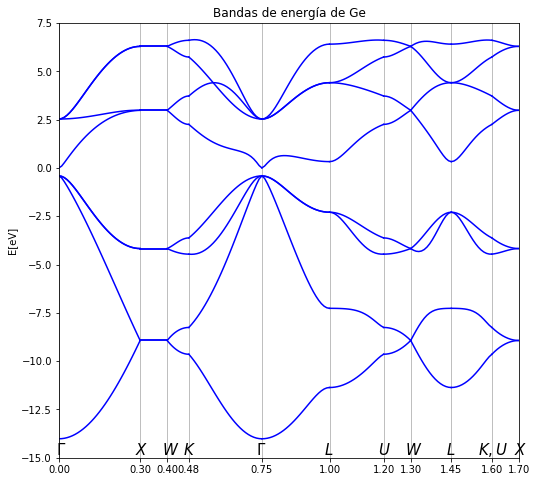

In [35]:
BandasGermanio(1,g) #Tercera corrección a = 3.2 b = 1.4

<IPython.core.display.Javascript object>


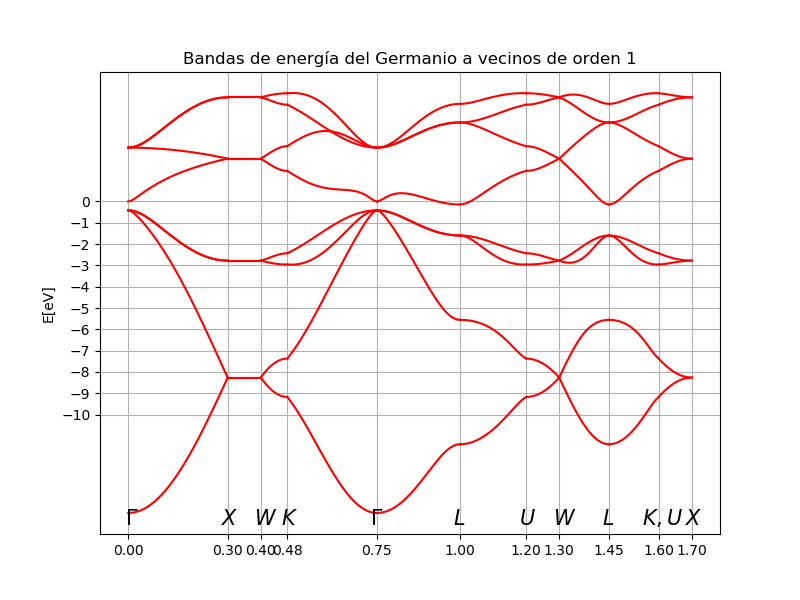

In [133]:
BandasGermanio(1,g) #Segunda corrección #a=3.5

<IPython.core.display.Javascript object>


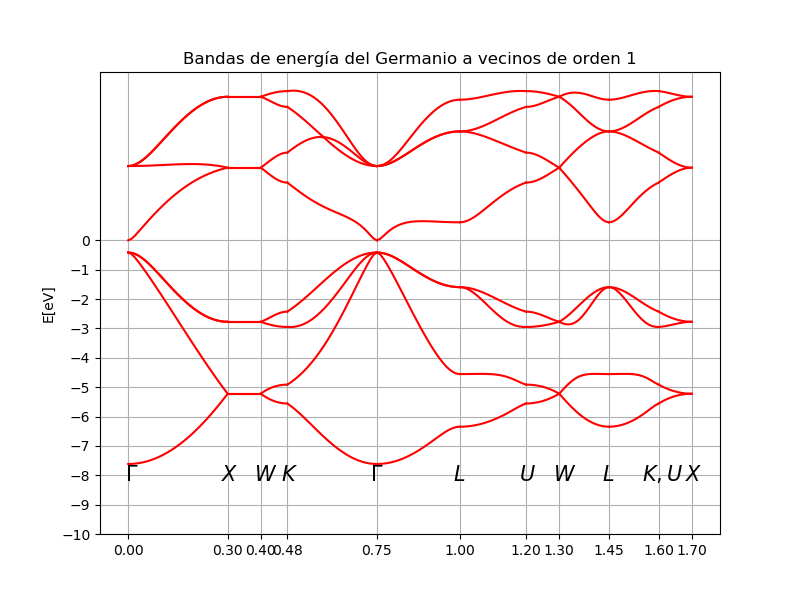

In [130]:
BandasGermanio(1,g) #Primera corrección

In [41]:
def BandasGermanio(n, g): #Comparación con el libro
    pts = Germanio.symp('fcc')
    G, KK, L, U, W, X = pts['G'], pts['K'], pts['L'], pts['U'], pts['W'], pts['X']
    Energia1 = Germanio.pathE(n, g, 0.05, [L,G,X], 100)
    Energia2 = Germanio.pathE(n, g, 0.05, [X,U], 100)
    Energia3 = Germanio.pathE(n, g, 0.05, [KK,G], 100)
    t1 = np.linspace(0,0.5, len(Energia1))
    t2 = np.linspace(0.5,0.6, len(Energia2))
    t3 = np.linspace(0.6,0.85, len(Energia3))
    fig = plt.figure(figsize=(6,6))
    plt.plot(t1, Energia1,'r')
    plt.plot(t2, Energia2,'r')
    plt.plot(t3, Energia3, 'r')
    ax = plt.gca()
    mi = min(np.amin(Energia1),np.amin(Energia2),np.amin(Energia3))-1.05
    plt.text(-0.01, mi, r'L', fontsize=15)
    plt.text(0.235, mi, r'$\Gamma$', fontsize=15)
    plt.text(0.485, mi, r'$X$', fontsize=15)
    plt.text(0.555, mi, r'$K,U$', fontsize=15)
    plt.text(0.835, mi, r'$\Gamma$', fontsize=15)
    ax.set_xticks([0,0.25,0.5,0.6,0.85], minor=False)
    ax.set_yticks([-12.5,-10.0,-7.5,-5.0,0,-2.5,2.5,5.0,7.5,10.0], minor=False)
    ax.xaxis.grid(True, which='major')
    plt.xlim(0,0.85)
    plt.ylabel('E[eV]')
    plt.title('Bandas de energía de Ge')
    plt.show()

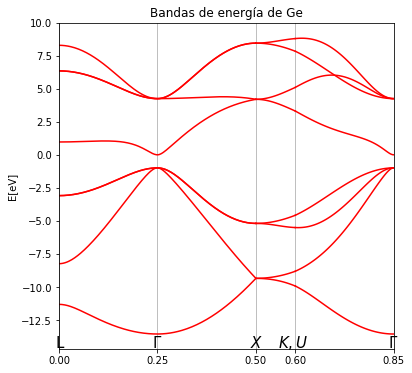

In [42]:
BandasGermanio(1,g)

#### Densidad de estados del Germanio:

In [21]:
H = Germanio.Hamiltoniano(1, g, 0.05)
Hk = sy.lambdify(K,H)

In [23]:
%%time
E = np.linspace(-15, 7.5, 300) #6:30
DOSE2 = Germanio.DOS(E, 1, g, 0.05, 30, Hk)

Wall time: 4h 25min 41s


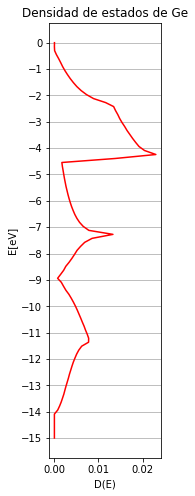

In [256]:
plt.figure(figsize=(2,8))
plt.plot(DOSE2, E,'r')
plt.ylabel('E[eV]')
plt.xlabel('D(E)') 
ax = plt.gca()
ax.set_yticks([-15.0,-12.5,-10.0,-7.5,-5.0,0,-2.5,2.5,5.0,7.5], minor=False) #Bandas de valencia
plt.ylim(-15,7.5)
ax.xaxis.grid(True, which='major')
plt.grid()
plt.title('Densidad de estados de Ge')
plt.show()

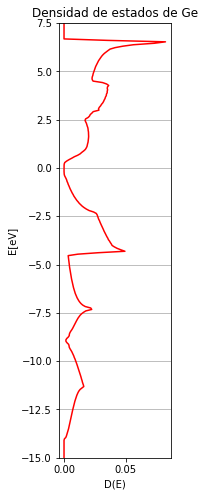

In [33]:
plt.figure(figsize=(2,8))
plt.plot(DOSE2, E,'r')
plt.ylabel('E[eV]')
plt.xlabel('D(E)')
ax = plt.gca()
ax.set_yticks([-15.0,-12.5,-10.0,-7.5,-5.0,0,-2.5,2.5,5.0,7.5], minor=False)
plt.ylim(-15,7.5)
ax.xaxis.grid(True, which='major')
plt.grid()
plt.title('Densidad de estados de Ge') #Todas las bandas
plt.show()